# Interpret regression models using Boston House Prices Dataset

This notebook demonstrates how to apply `Captum` library on a regression model and understand important features, layers / neurons that contribute to the prediction. It compares a number of attribution algorithms from `Captum` library for a simple DNN models trained on a sub-sample of a well-known boston house prices dataset.

Note that in order to be able to run this notebook successfully you need to install scikit-learn package in advance.


In [1]:
import numpy as np

from os import path

import sklearn
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation


## Data loading and pre-processing

Let's load boston house prices dataset and corresponding labels from scikit-learn library. 

In [2]:
boston = load_boston()

# feature_names -> ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
feature_names = boston.feature_names

X = boston.data
y = boston.target


In order to retain deterministic results, let's fix the seeds.

In [3]:
torch.manual_seed(0)
np.random.seed(0)


### Standardizing Data

Let's standardize the dataset by removing the mean and scaling to unit variance. This helps us to gain slightly better accuracy.

In [4]:
scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)


Let's use 70% of our data for training and the remaining 30% for testing.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=0)


# Data Exploration

Let's visualize dependent variable vs each independent varaible in a separate plot. Apart from that we will also perform a simple one degree polynomial fit and plot the fitted line in dashed, red color.

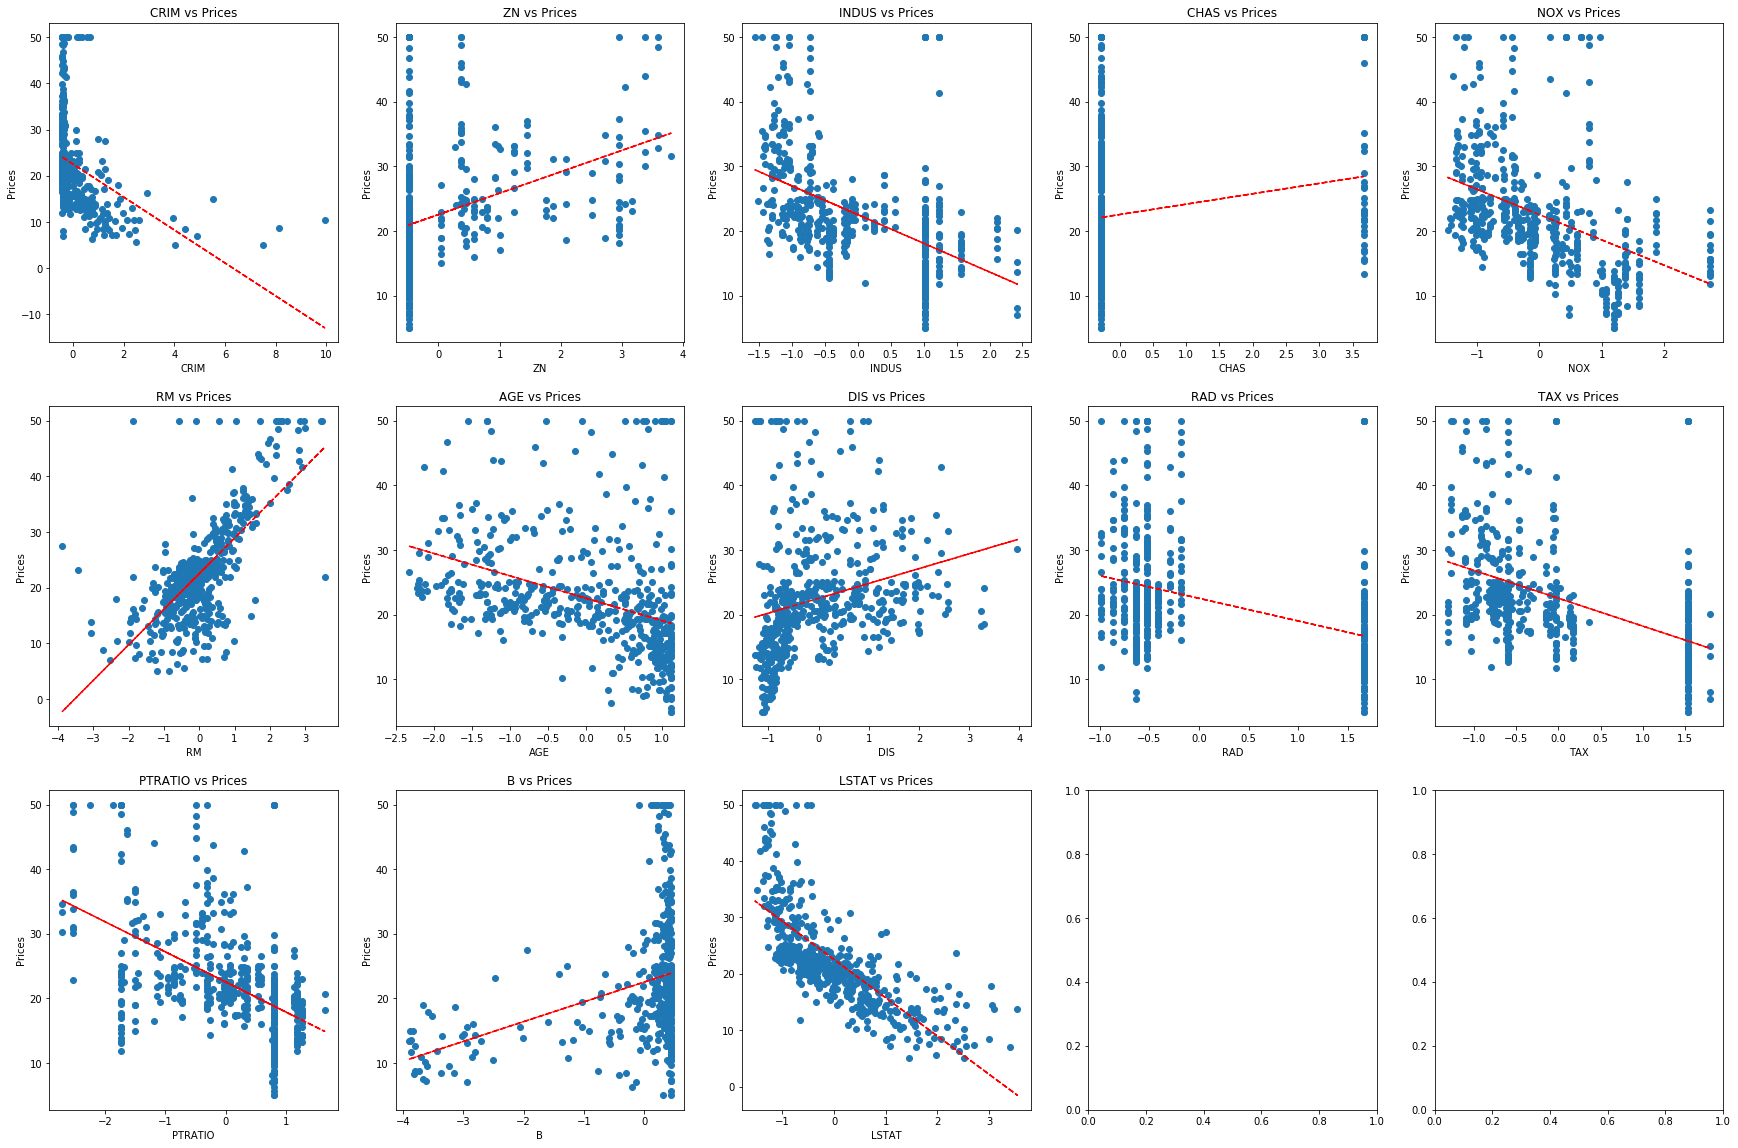

In [6]:
fig, axs = plt.subplots(nrows = 3, ncols=5, figsize=(30, 20))
for i, (ax, col) in enumerate(zip(axs.flat, feature_names)):
    x = X_norm[:,i]
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)

    ax.plot(x, y, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs Prices')
    ax.set_xlabel(col)
    ax.set_ylabel('Prices')


From the diagram above we can tell that some of the most influential features that are correlated with the output price are:   
   - RM, the average numbers of rooms in the houses of the neighborhood.
     If RM increases the house price increases too.
   - LSTAT, the percentage of the house-owners in the neighborhood (lower class)
     This variable is negatively correlated with the price. The lower the class the less likely is that the person will be able to afford an expensive house

# Tensorizing inputs and creating batches

Below we tensorize input features and corresponding labels.


In [7]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)


Defining default hyper parameters for the model.


In [8]:
batch_size = 50
num_epochs = 200
learning_rate = 0.01
size_hidden= 50


We will have two models. One is a simple linear model which is similar to linear regression and the other one is a bit more evolved and contains additional two layers: a relu and a linear layer.

In [9]:
class BostonModelSimple(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(13, 1)

    def forward(self, input):
        return self.lin(input)


class BostonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(13, size_hidden)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden, 1)

    def forward(self, input):
        return self.lin2(self.relu(self.lin1(input)))


In [10]:
model_smpl = BostonModelSimple()
model_smpl.train()

model = BostonModel()
model.train()


BostonModel(
  (lin1): Linear(in_features=13, out_features=50, bias=True)
  (relu): ReLU()
  (lin2): Linear(in_features=50, out_features=1, bias=True)
)

## Train Boston Model

First of all let's initialize the weights and biases.
The weights are initialized by drawing values from normal distribution with 0 mean and 0.1 standard deviation and biases are initialized with 0 values.


In [11]:
## initialize weights and parameters

torch.nn.init.normal_(model_smpl.lin.weight, mean=0, std=0.1)
torch.nn.init.constant_(model_smpl.lin.bias, val=0)


torch.nn.init.normal_(model.lin1.weight, mean=0, std=0.1)
torch.nn.init.constant_(model.lin1.bias, val=0)

torch.nn.init.normal_(model.lin2.weight, mean=0, std=0.1)
torch.nn.init.constant_(model.lin2.bias, val=0)


Parameter containing:
tensor([0.], requires_grad=True)

In [12]:
criterion = nn.MSELoss(reduction='sum')

A function that trains a simple regression model using RMSprop and given input hyperparameters.

In [13]:
def train(model_inp, num_epochs = num_epochs):
    optimizer = torch.optim.RMSprop(model_inp.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0


If the model was previously trained and stored, we load that pre-trained model, otherwise, we train a new model and store it for future uses.

In [14]:
def train_load_save_model(model_obj, model_path):
    if path.isfile(model_path):
        # load model
        print('Loading pre-trained model from: {}'.format(model_path))
        model_obj.load_state_dict(torch.load(model_path))
    else:    
        # train model
        train(model_obj)
        print('Finished training the model. Saving the model to the path: {}'.format(model_path))
        torch.save(model_obj.state_dict(), model_path)

In [15]:
SAVED_MODEL_SMPL_PATH = 'models/boston_model_smpl.pt'
SAVED_MODEL_PATH = 'models/boston_model.pt'

train_load_save_model(model_smpl,SAVED_MODEL_SMPL_PATH)
train_load_save_model(model, SAVED_MODEL_PATH)

Loading pre-trained model from: models/boston_model_smpl.pt
Loading pre-trained model from: models/boston_model.pt


Let's perform a simple sanity check and compute the performance of the model using Root Squared Mean Error (RSME) metric.

In [16]:
model_smpl.eval()
outputs = model_smpl(X_test)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))
print('simple model err: ', err)

model.eval()
outputs = model(X_test)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))
print('model err: ', err)


simple model err:  5.235897
model err:  3.9368422


From the result above we can tell that the second model performs much better. 

The first model performs approximately as good as the vanilla regression model from sci-kit learn: 
https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_boston_prediction.html

# Comparing different attribution algorithms

Let's compute the attributions with repect to the inputs of the model using different attribution algorithms from core `Captum` library and visualize those attributions. We start with out simple model and use test dataset as the input features.

We use mainly default settings, such as default baselines, number of steps etc., for all algorithms. For GradientSHAP specifically we use the entire training dataset as the distribution of baselines.

In [17]:
ig = IntegratedGradients(model_smpl)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model_smpl)
gs = GradientShap(model_smpl)
fa = FeatureAblation(model_smpl)

ig_attr_test = ig.attribute(X_test)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)


/data/users/narine/captum/captum/attr/_utils/gradient.py:32: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/data/users/narine/captum/captum/attr/_core/deep_lift.py:256: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


Now let's visualize attribution scores with respect to inputs (using test dataset) for our simple model in one plot. This will help us to understand how similar or different the attribution scores assigned from different attribution algorithms are. Apart from that we will also compare attribution scores with the learned model weights.


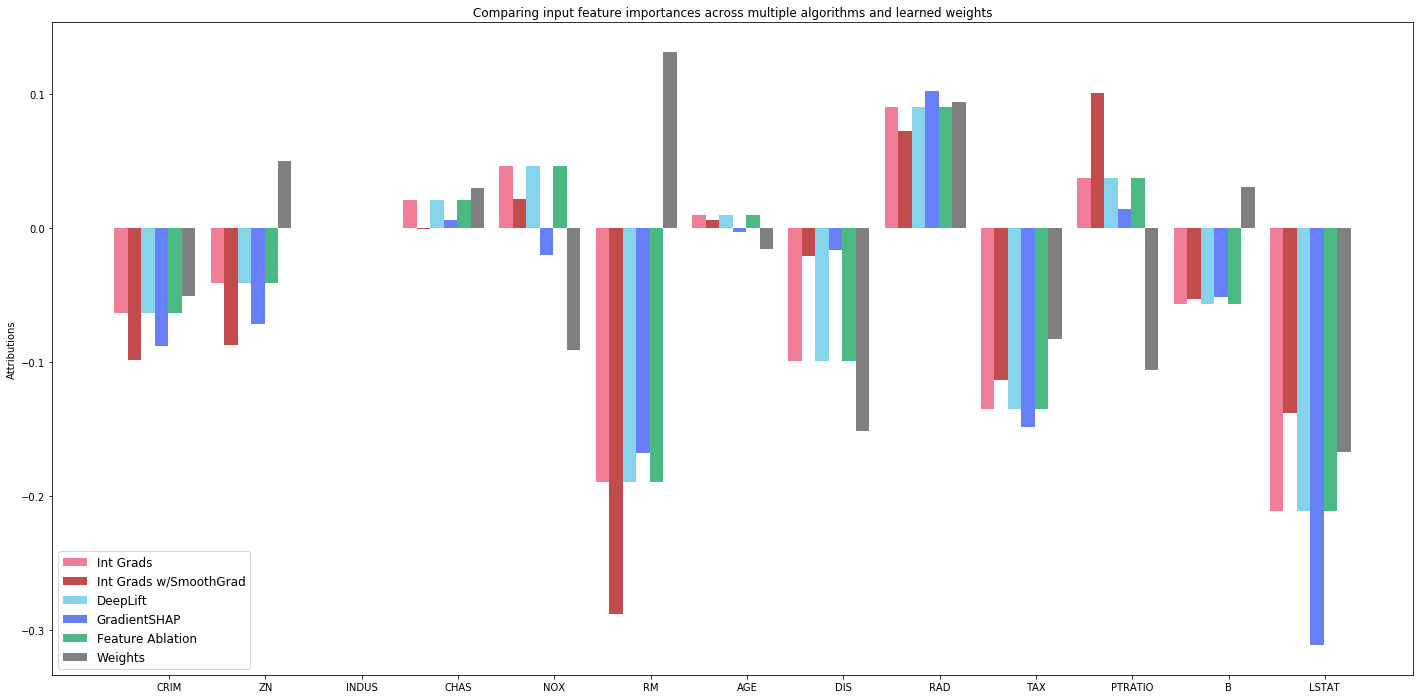

In [18]:
# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model_smpl.lin.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()


The magnitudes of learned model weights tell us about the correlations between the dependent variable `Price` and each independent variable. Zero weight means no correlation whereas positive weights indicates positive correlations and negative the opposite.

From the plot above we can see that our top features are `LSTAT` and `RM`. This is based on both attribution scores and model weights. One interesting thing to observe is that according to the learned coefficients and our analysis above, `RM` is positively correlated with the output variable, `Price`, however this is not true for the attributions. 
Attribution algorithms all voted for negative correlation between `RM` and `Price` with relatively high importance magnitudes. In terms of the feature `LSTAT`, we observe that all attribution algorithms and learned coefficients voted for high negative correlation with the dependent variable `Price`.

In terms of least important features, we observe that `INDUS` and `AGE` are voted to be least important both from all attribution algorithms and learned coefficients.

Another interesting observation is that both Integrated Gradients and DeepLift return almost identical attribution scores across all features. Since we do not have any non-linearities in this simple model, DeepLift is equivalent to `(input - baselines) * gradients` and in this specific simple example gradients remain constant for all inputs along the straight line between the baseline and input. Thus, in this specific case Deeplift and Integrated Gradients are almost identical.


## Experimenting with a more complex model

Now let's look into our slighltly more complex model. Besides attributing to the inputs of the model, we'd also like to attribute to the layers of the model and understand which neurons appear to be more important.

In the cell below we will attribute to the inputs of the second linear layer of our model. Similar to the previous case, the attribution is perfomed on the test dataset.

In [19]:
# Computes activations that are the inputs to the second linear layer
la = LayerActivation(model, model.relu)
la_attr_test = la.attribute(X_test, attribute_to_layer_input=True)

# test_examples x #features
la_attr_test = la_attr_test[0]

# Compute the attributions of the output with respect to the inputs of the second linear layer
lc = LayerConductance(model, model.lin2)
lc_attr_test = lc.attribute(X_test, attribute_to_layer_input=True)

# test_examples x size_hidden
lc_attr_test = lc_attr_test[0]

# weights from second linear layer
lin2_weight = model.lin2.weight


In the cell below we normalize and visualize the attributions, learned model weights and activations for each 50 neurons in the hidden layer. 
The activations represent the outputs of the first layer and the weights represent the weight matrix of the second linear layer. The attributions are computed with respect to the inputs of the second layer.

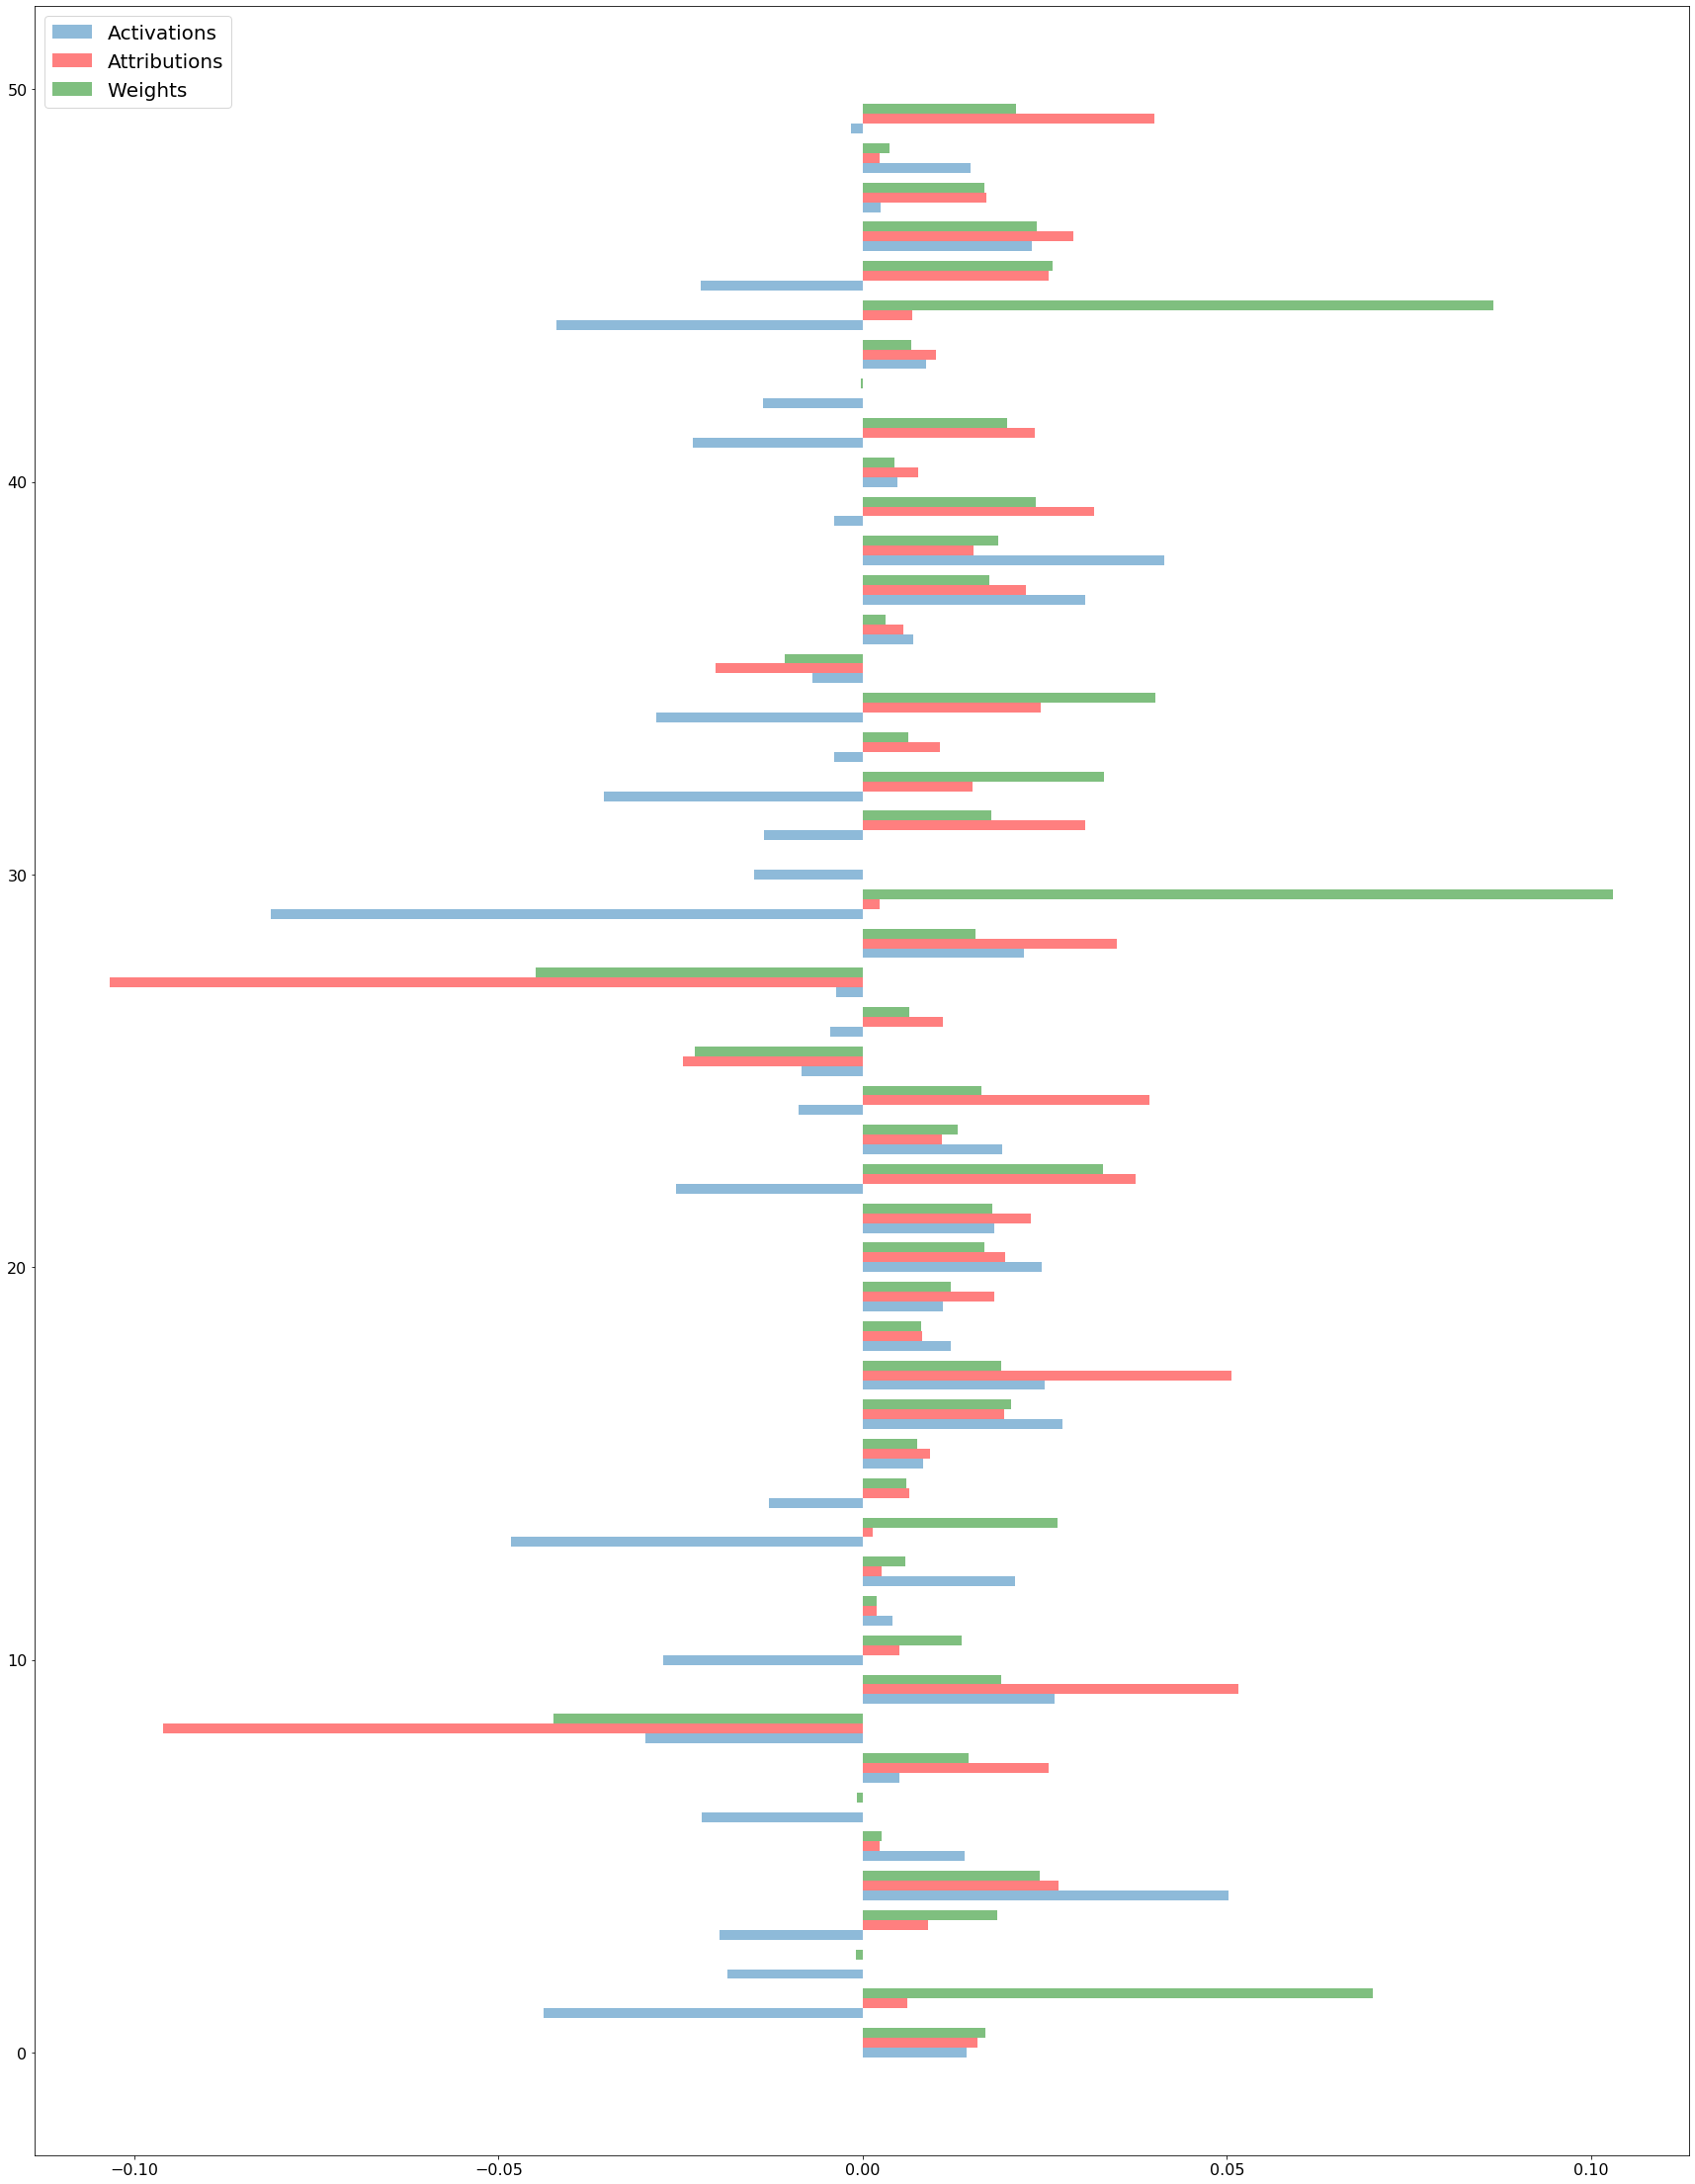

In [20]:
plt.figure(figsize=(30, 40))

x_axis_data = np.arange(la_attr_test.shape[1])

y_axis_la_attr_test = la_attr_test.sum(0).detach().numpy()
y_axis_la_attr_test = y_axis_la_attr_test / np.linalg.norm(y_axis_la_attr_test, ord=1)

y_axis_lc_attr_test = lc_attr_test.sum(0).detach().numpy()
y_axis_lc_attr_test = y_axis_lc_attr_test / np.linalg.norm(y_axis_lc_attr_test, ord=1)

y_axis_lin2_weight = lin2_weight[0].detach().numpy()
y_axis_lin2_weight = y_axis_lin2_weight / np.linalg.norm(y_axis_lin2_weight, ord=1)

width = 0.25
legends = ['Activations', 'Attributions','Weights']
ax = plt.subplot()
ax.barh(x_axis_data, y_axis_la_attr_test, width, align='center', alpha=0.5)
ax.barh(x_axis_data + width, y_axis_lc_attr_test, width, align='center', alpha=0.5, color='red')
ax.barh(x_axis_data + 2 * width, y_axis_lin2_weight, width, align='center', alpha=0.5, color='green')
plt.legend(legends, loc=2, prop={'size': 20})
plt.show()


It is interesting to observe that the weights and attribution scores are well aligned. Meaning that the neurons with negative weights also have negative attribution scores and we can observe the same for the positive weights and attributions. 

Another important thing to note is that there are a number of neurons that are being voted to be unimportant based on both attribution, weight scores and activation values. 